In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib
import pickle
from sklearn.model_selection import train_test_split

import warnings

warnings.filterwarnings("ignore")

from ti import *

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing

from pmdarima import auto_arima

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from tensorflow.keras.optimizers import Adam

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score

In [3]:
df = pd.read_csv("./data/stocks_ti.csv")

df["DATE"] = pd.to_datetime(df["DATE"])

df.set_index("DATE", inplace=True)

df

,SPY_3M IMPLIED VOL,SPY_HIGH,SPY_LOW,SPY_OPEN,SPY_SHORT INTEREST RATIO,SPY_ewm_log_ret_13d,SPY_ewm_log_ret_1d,SPY_ewm_log_ret_21d,SPY_ewm_log_ret_3d,SPY_ewm_log_ret_5d,...,XRT_macd_sig,XRT_rsi,XRT_rsi_13d_slope,XRT_rsi_1d_slope,XRT_rsi_21d_slope,XRT_rsi_3d_slope,XRT_rsi_5d_slope,XRT_rsi_8d_slope,tweet_sentiment,news_sentiment
DATE,,,,,,,,,,,,,,,,,,,,,
2015-01-02,14.0384,0.006498,-0.006639,0.004078,1.507,0.005375,-0.000535,0.006782,-0.010765,-0.000939,...,0.598815,67.988107,19.826342,-7.838144,5.204016,-1.944891,7.252436,10.295799,-0.131934,0.075776
2015-01-05,14.1676,-0.005173,-0.020061,-0.006152,1.507,0.006181,-0.018225,0.003427,-0.019749,-0.011550,...,0.593092,59.339623,16.598506,-8.648484,-0.103102,-8.596080,-3.993711,0.899108,-0.102601,0.116118
2015-01-06,14.3399,0.004945,-0.014305,0.001833,1.507,0.006670,-0.009464,-0.000383,-0.023986,-0.022225,...,0.567309,53.461876,14.660032,-5.877747,-4.602641,-22.364376,-16.471123,-4.402835,0.025503,0.050569
2015-01-07,14.4772,0.014409,0.005291,0.007975,1.507,0.006085,0.012384,-0.002870,-0.019645,-0.023421,...,0.548476,67.244094,17.009353,13.782219,11.666405,-0.744013,-0.691608,6.508423,-0.051485,0.125229
2015-01-08,14.5777,0.018851,0.008270,0.008368,1.507,0.004606,0.017589,-0.002922,0.000432,-0.015031,...,0.544027,64.685908,12.113201,-2.558186,7.219379,5.346286,-11.140343,1.352575,0.100507,0.138343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,12.9785,0.000934,-0.000997,0.000778,2.463,0.021663,0.000031,0.028050,0.003051,0.008625,...,0.359009,67.779961,23.646861,-0.862487,24.291589,8.342875,14.908339,-0.857149,-0.048913,0.238482
2019-12-26,12.9736,0.005340,0.001276,0.001307,2.463,0.022183,0.005309,0.028235,0.004959,0.009226,...,0.380095,71.863118,22.659296,4.083157,26.104189,8.547421,17.008749,15.327685,0.195297,0.277311
2019-12-27,12.9749,0.002659,-0.002046,0.002474,2.463,0.023044,-0.000248,0.028175,0.005026,0.008180,...,0.403777,66.666667,15.808632,-5.196451,15.789474,-1.975781,7.229581,16.047198,0.027661,0.249240


In [4]:
df.columns[:30]

Index(['SPY_3M IMPLIED VOL', 'SPY_HIGH', 'SPY_LOW', 'SPY_OPEN',
       'SPY_SHORT INTEREST RATIO', 'SPY_ewm_log_ret_13d', 'SPY_ewm_log_ret_1d',
       'SPY_ewm_log_ret_21d', 'SPY_ewm_log_ret_3d', 'SPY_ewm_log_ret_5d',
       'SPY_ewm_log_ret_8d', 'SPY_ivol_13d_slope', 'SPY_ivol_1d_slope',
       'SPY_ivol_21d_slope', 'SPY_ivol_3d_slope', 'SPY_ivol_5d_slope',
       'SPY_ivol_8d_slope', 'SPY_log_ret_13d', 'SPY_log_ret_1d',
       'SPY_log_ret_21d', 'SPY_log_ret_3d', 'SPY_log_ret_5d', 'SPY_log_ret_8d',
       'SPY_macd', 'SPY_macd_13d_slope', 'SPY_macd_1d_slope',
       'SPY_macd_21d_slope', 'SPY_macd_3d_slope', 'SPY_macd_5d_slope',
       'SPY_macd_8d_slope'],
      dtype='object')

<Axes: xlabel='DATE'>

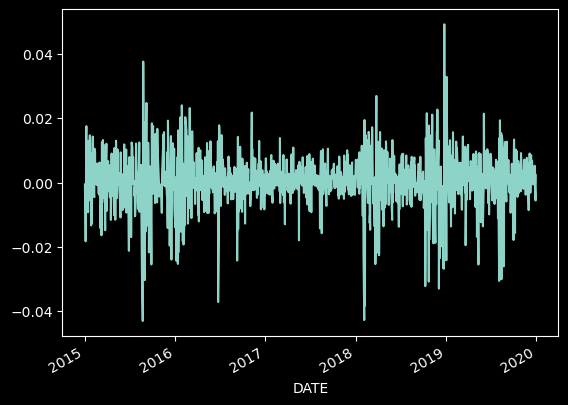

In [5]:
df["SPY_log_ret_1d"].plot()

# Functions

In [6]:
def prepare_X_y(X, y, test_size=0.2):
    # Calculate split index
    split_idx = int(len(X) * (1 - test_size))

    # Split into training and testing sets based on the calculated index
    X_train = X.iloc[:split_idx]
    X_test = X.iloc[split_idx:]
    y_train = y.iloc[:split_idx]
    y_test = y.iloc[split_idx:]

    # Standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert scaled arrays back to DataFrames for easier handling in later processes
    X_train_scaled = pd.DataFrame(
        X_train_scaled, columns=X_train.columns, index=X_train.index
    )
    X_test_scaled = pd.DataFrame(
        X_test_scaled, columns=X_test.columns, index=X_test.index
    )

    return (X_train_scaled, X_test_scaled, y_train, y_test)


# def prepare_X_y(X, y, test_size=0.2):
#     # Split into training and testing sets randomly
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=test_size, random_state=42
#     )

#     # Standardization
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)

#     # Convert scaled arrays back to DataFrames for easier handling in later processes
#     X_train_scaled = pd.DataFrame(
#         X_train_scaled, columns=X_train.columns, index=X_train.index
#     )
#     X_test_scaled = pd.DataFrame(
#         X_test_scaled, columns=X_test.columns, index=X_test.index
#     )

#     return (X_train_scaled, X_test_scaled, y_train, y_test)

In [7]:
def test_accuracy_f1_roc_auc(model, X_test, y_test):
    """
    Calculates and prints the accuracy, F1 score, and ROC AUC for the test set. Also, plots the ROC curve.

    Parameters:
    - model: The trained classifier to evaluate
    - X_test: Testing features
    - y_test: Testing target variable (class labels)
    """
    # Predict class labels
    predictions = model.predict(X_test)
    # Predict probabilities for the positive class
    probabilities = model.predict_proba(X_test)[:, 1]

    # Calculate accuracy
    accuracy = accuracy_score(y_test, predictions)
    # Calculate F1 score
    f1 = f1_score(y_test, predictions)
    # Calculate ROC AUC
    roc_auc = roc_auc_score(y_test, probabilities)

    # Print accuracy, F1 score, and ROC AUC
    print(f"Accuracy: {accuracy}, F1 Score: {f1}, ROC AUC: {roc_auc}")

    # Plotting ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    plt.figure()
    plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], "k--")  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.legend(loc="lower right")
    plt.show()

    return accuracy, f1, roc_auc

In [8]:
def train_random_forest(X_train, y_train, n_estimators=100, max_depth=None):
    """
    Trains and fits a Random Forest model for classification.

    Parameters:
    - X_train: Training features
    - y_train: Training target variable (class labels)
    - n_estimators: The number of trees in the forest
    - max_depth: The maximum depth of the tree

    Returns:
    - A trained Random Forest Classifier model
    """
    model = RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth, random_state=42
    )
    model.fit(X_train, y_train)
    return model


def run_grid_search(model, param_grid, X_train, y_train, n_splits=3):
    # tscv = TimeSeriesSplit(n_splits=n_splits)
    # gscv = GridSearchCV(
    #     estimator=model, param_grid=param_grid, cv=tscv, verbose=2, n_jobs=-1
    # )

    gscv = GridSearchCV(
        estimator=model, param_grid=param_grid, cv=n_splits, verbose=2, n_jobs=-1
    )
    gscv.fit(X_train, y_train)
    return gscv

# Set 1: only price and vol data ~ 1day log return

In [9]:
y = df["SPY_log_ret_1d"][1:]
y = (y > 0).astype(int)

X1 = df[
    [
        "SPY_3M IMPLIED VOL",
        "SPY_HIGH",
        "SPY_LOW",
        "SPY_OPEN",
        "SPY_SHORT INTEREST RATIO",
        "SPY_ivol_13d_slope",
        "SPY_ivol_1d_slope",
        "SPY_ivol_21d_slope",
        "SPY_ivol_3d_slope",
        "SPY_ivol_5d_slope",
        "SPY_ivol_8d_slope",
        "SPY_log_ret_13d",
    ]
][:-1]

(X_train1, X_test1, y_train1, y_test1) = prepare_X_y(X1, y, test_size=0.2)

## Linear regression

In [10]:
# Initialize the Logistic Regression model
lr_model = LogisticRegression()

# Fit the model with the training data
lr_model.fit(X_train1, y_train1)

# The coefficients and intercept
coefficients = lr_model.coef_
intercept = lr_model.intercept_

# Predict on the training data
# Predicted probabilities
y_train_pred_proba = lr_model.predict_proba(X_train1)
# Predicted classes
y_train_pred = lr_model.predict(X_train1)

# Calculate metrics on training data
# Log Loss
train_log_loss = log_loss(y_train1, y_train_pred_proba)
# Accuracy
train_accuracy = accuracy_score(y_train1, y_train_pred)

# Predict on the testing data
# Predicted probabilities
y_test_pred_proba = lr_model.predict_proba(X_test1)
# Predicted classes
y_test_pred = lr_model.predict(X_test1)

# Calculate metrics on testing data
# Log Loss
test_log_loss = log_loss(y_test1, y_test_pred_proba)
# Accuracy
test_accuracy = accuracy_score(y_test1, y_test_pred)

{
    "coefficients": coefficients.flatten(),  # Flatten to make it a 1D array for simplicity
    "intercept": intercept,
    "training_metrics": {"Log Loss": train_log_loss, "Accuracy": train_accuracy},
    "testing_metrics": {"Log Loss": test_log_loss, "Accuracy": test_accuracy},
}

{'coefficients': array([-0.06194184, -0.16611091, -0.17593133,  0.20348706,  0.00577191,
        -0.46888822, -0.20814377,  0.16305472, -0.05892193,  0.50174405,
         0.11779283, -0.05215891]),
 'intercept': array([0.1159139]),
 'training_metrics': {'Log Loss': 0.684000902362986,
  'Accuracy': 0.5545545545545546},
 'testing_metrics': {'Log Loss': 0.7031822853106906, 'Accuracy': 0.492}}

Accuracy: 0.492, F1 Score: 0.563573883161512, ROC AUC: 0.46641494435612085


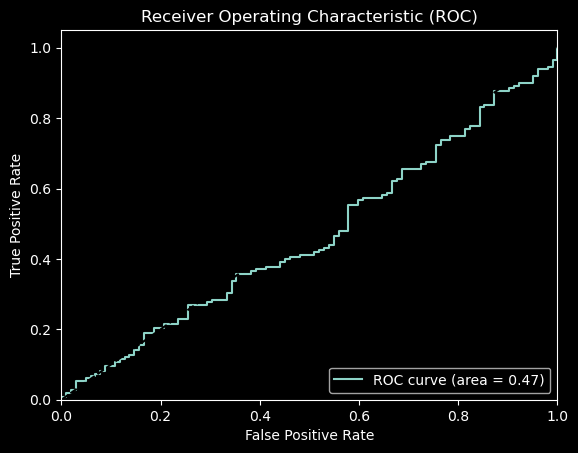

(0.492, 0.563573883161512, 0.46641494435612085)

In [11]:
test_accuracy_f1_roc_auc(lr_model, X_test1, y_test1)

## Random Forest

In [12]:
model_rf1 = train_random_forest(X_train1, y_train1, n_estimators=100, max_depth=None)

# Perform Grid Search with Time Series Cross-Validation
param_grid = {
    "n_estimators": [50, 100, 200, 400],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

In [13]:
best_model_rf1 = run_grid_search(model_rf1, param_grid, X_train1, y_train1, n_splits=3)

# Display the best parameters and score
print(f"Best Parameters: {best_model_rf1.best_params_}")
print(f"Best Score: {best_model_rf1.best_score_}")

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_dep

Accuracy: 0.532, F1 Score: 0.5650557620817843, ROC AUC: 0.525172231054584


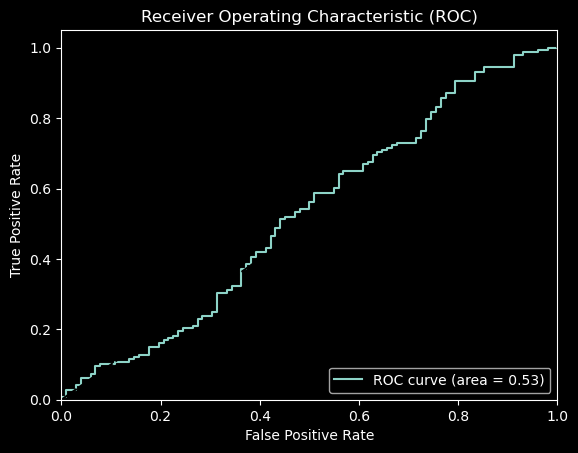

(0.532, 0.5650557620817843, 0.525172231054584)

In [15]:
test_accuracy_f1_roc_auc(best_model_rf1, X_test1, y_test1)

# Set 2: spy + ti (spy)

In [16]:
df.columns[23:38]

Index(['SPY_macd', 'SPY_macd_13d_slope', 'SPY_macd_1d_slope',
       'SPY_macd_21d_slope', 'SPY_macd_3d_slope', 'SPY_macd_5d_slope',
       'SPY_macd_8d_slope', 'SPY_macd_sig', 'SPY_rsi', 'SPY_rsi_13d_slope',
       'SPY_rsi_1d_slope', 'SPY_rsi_21d_slope', 'SPY_rsi_3d_slope',
       'SPY_rsi_5d_slope', 'SPY_rsi_8d_slope'],
      dtype='object')

In [17]:
y = df["SPY_log_ret_1d"][1:]
y = (y > 0).astype(int)

X2 = pd.concat([df.iloc[:, 0:11], df.iloc[:, 23:38]], axis=1)[:-1]

(X_train2, X_test2, y_train2, y_test2) = prepare_X_y(X2, y, test_size=0.2)

## Logistics regression

In [18]:
# Initialize the Logistic Regression model
lr_model2 = LogisticRegression()

# Fit the model with the training data
lr_model2.fit(X_train2, y_train2)

# The coefficients and intercept
coefficients2 = lr_model2.coef_
intercept2 = lr_model2.intercept_

# Predict on the training data
# Predicted probabilities
y_train_pred_proba2 = lr_model2.predict_proba(X_train2)
# Predicted classes
y_train_pred2 = lr_model2.predict(X_train2)

# Calculate metrics on training data
# Log Loss
train_log_loss2 = log_loss(y_train2, y_train_pred_proba2)
# Accuracy
train_accuracy2 = accuracy_score(y_train2, y_train_pred2)

# Predict on the testing data
# Predicted probabilities
y_test_pred_proba2 = lr_model2.predict_proba(X_test2)
# Predicted classes
y_test_pred2 = lr_model2.predict(X_test2)

# Calculate metrics on testing data
# Log Loss
test_log_loss2 = log_loss(y_test2, y_test_pred_proba2)
# Accuracy
test_accuracy2 = accuracy_score(y_test2, y_test_pred2)

{
    "coefficients": coefficients2.flatten(),  # Flatten to make it a 1D array for simplicity
    "intercept": intercept2,
    "training_metrics": {"Log Loss": train_log_loss2, "Accuracy": train_accuracy2},
    "testing_metrics": {"Log Loss": test_log_loss2, "Accuracy": test_accuracy2},
}

{'coefficients': array([-0.08414327, -0.37220683, -0.31502005,  0.28912094, -0.0090815 ,
        -0.15450191,  0.10236789, -0.13594351, -0.32666613,  0.13440303,
         0.12547537,  0.04634951, -0.17945656,  0.31855276,  0.23811798,
         0.26857139, -0.47573129, -0.01858699,  0.03449958,  0.03102145,
         0.05532306,  0.13743038, -0.04723621, -0.05898263,  0.03476419,
        -0.12392982]),
 'intercept': array([0.11666786]),
 'training_metrics': {'Log Loss': 0.6804855731756781,
  'Accuracy': 0.5565565565565566},
 'testing_metrics': {'Log Loss': 0.7022890973052872, 'Accuracy': 0.46}}

Accuracy: 0.46, F1 Score: 0.5296167247386759, ROC AUC: 0.47992845786963434


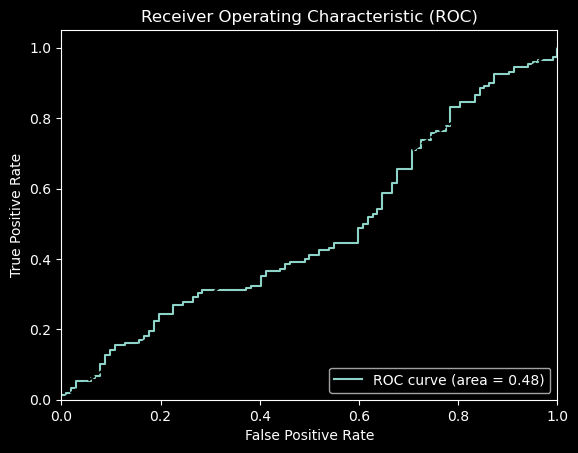

(0.46, 0.5296167247386759, 0.47992845786963434)

In [19]:
test_accuracy_f1_roc_auc(lr_model2, X_test2, y_test2)

## Random Forest

In [20]:
model_rf2 = train_random_forest(X_train2, y_train2, n_estimators=100, max_depth=None)

In [21]:
best_model_rf2 = run_grid_search(model_rf2, param_grid, X_train2, y_train2, n_splits=3)

# Display the best parameters and score
print(f"Best Parameters: {best_model_rf2.best_params_}")
print(f"Best Score: {best_model_rf2.best_score_}")

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_dep

Accuracy: 0.468, F1 Score: 0.4743083003952569, ROC AUC: 0.4603868574456809


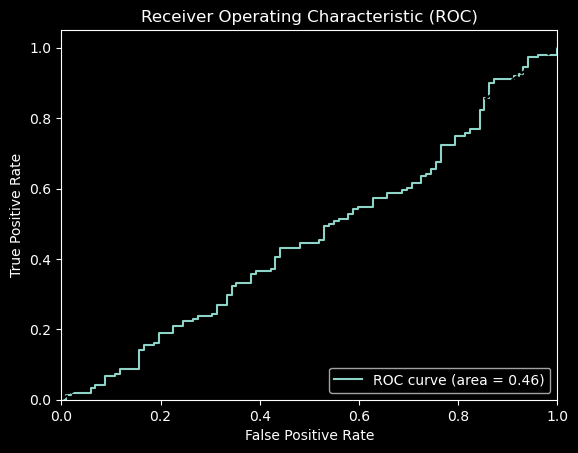

(0.468, 0.4743083003952569, 0.4603868574456809)

In [23]:
test_accuracy_f1_roc_auc(best_model_rf2, X_test2, y_test2)

# Set 3: spy + sector + ti (spy & sectors)

In [24]:
y = df["SPY_log_ret_1d"][1:]
y = (y > 0).astype(int)

X3 = pd.concat([df.iloc[:, 0:11], df.iloc[:, 23:-2]], axis=1)[:-1].ffill()

(X_train3, X_test3, y_train3, y_test3) = prepare_X_y(X3, y, test_size=0.2)

## Linear regression

In [25]:
# Initialize the Logistic Regression model
lr_model3 = LogisticRegression()

# Fit the model with the training data
lr_model3.fit(X_train3, y_train3)

# The coefficients and intercept
coefficients3 = lr_model3.coef_
intercept3 = lr_model3.intercept_

# Predict on the training data
# Predicted probabilities
y_train_pred_proba3 = lr_model3.predict_proba(X_train3)
# Predicted classes
y_train_pred3 = lr_model3.predict(X_train3)

# Calculate metrics on training data
# Log Loss
train_log_loss3 = log_loss(y_train3, y_train_pred_proba3)
# Accuracy
train_accuracy3 = accuracy_score(y_train3, y_train_pred3)

# Predict on the testing data
# Predicted probabilities
y_test_pred_proba3 = lr_model3.predict_proba(X_test3)
# Predicted classes
y_test_pred3 = lr_model3.predict(X_test3)

# Calculate metrics on testing data
# Log Loss
test_log_loss3 = log_loss(y_test3, y_test_pred_proba3)
# Accuracy
test_accuracy3 = accuracy_score(y_test3, y_test_pred3)

{
    "coefficients": coefficients3.flatten(),  # Flatten to make it a 1D array for simplicity
    "intercept": intercept3,
    "training_metrics": {"Log Loss": train_log_loss3, "Accuracy": train_accuracy3},
    "testing_metrics": {"Log Loss": test_log_loss3, "Accuracy": test_accuracy3},
}

{'coefficients': array([ 3.81397597e-01, -2.38119567e-01, -4.54258101e-01,  7.90428465e-01,
         1.30758565e-01, -6.42026018e-01, -1.74076071e-01, -5.83959563e-01,
        -6.54208941e-01, -4.44319946e-01, -1.24748457e-01, -5.94746797e-01,
        -6.91112019e-02, -5.78703717e-02,  1.93541284e-01,  7.62698895e-02,
        -1.69295570e-02,  2.28361448e-01, -6.99074591e-01, -1.10803186e+00,
         2.57602904e-01, -3.04448477e-01,  2.01254679e-01,  2.75323596e-01,
         3.58026543e-01,  3.80130356e-01, -2.87156182e-01, -1.94766322e-01,
         1.87558506e-03, -3.19831014e-01, -1.14118866e-01, -2.36417487e-01,
         1.80061700e-01, -1.28801209e-01,  2.48706449e-03,  1.91615964e-01,
         6.80823633e-01,  2.01616765e-01,  6.77834536e-01,  6.02298555e-01,
        -7.97973528e-01, -6.23724518e-01,  7.17995105e-02,  5.33648816e-01,
         1.80061700e-01,  8.38722556e-01, -2.44956368e-01, -3.55652932e-01,
         5.99041115e-01, -1.71392482e-01, -5.70991953e-01, -1.38935097e-

Accuracy: 0.46, F1 Score: 0.5263157894736842, ROC AUC: 0.45608108108108103


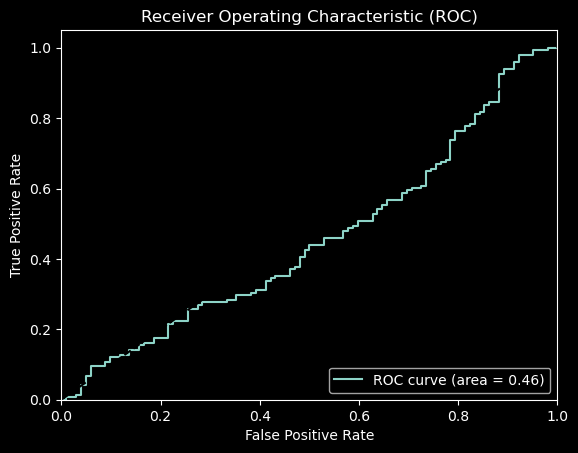

(0.46, 0.5263157894736842, 0.45608108108108103)

In [27]:
test_accuracy_f1_roc_auc(lr_model3, X_test3, y_test3)

# Random Forest

In [28]:
model_rf3 = train_random_forest(X_train3, y_train3, n_estimators=100, max_depth=None)

In [29]:
best_model_rf3 = run_grid_search(model_rf3, param_grid, X_train3, y_train3, n_splits=3)

# Display the best parameters and score
print(f"Best Parameters: {best_model_rf3.best_params_}")
print(f"Best Score: {best_model_rf3.best_score_}")

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_dep

Accuracy: 0.484, F1 Score: 0.5019305019305019, ROC AUC: 0.4607843137254902


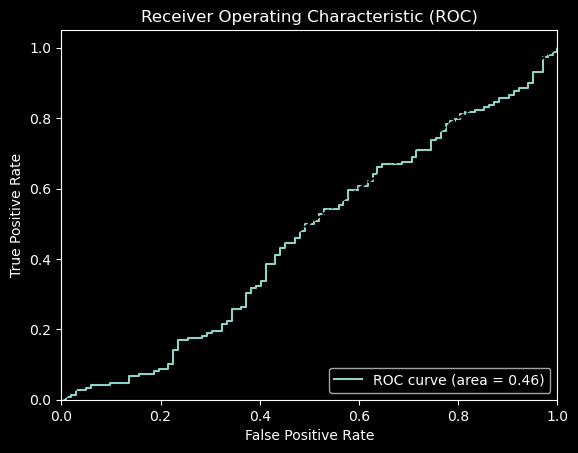

(0.484, 0.5019305019305019, 0.4607843137254902)

In [30]:
test_accuracy_f1_roc_auc(best_model_rf3, X_test3, y_test3)

# Set 4: All (including Tweet Sentiment and News Sentiment)

In [31]:
y = df["SPY_log_ret_1d"][1:]
y = (y > 0).astype(int)

X4 = pd.concat([df.iloc[:, 0:11], df.iloc[:, 23:]], axis=1)[:-1].ffill()

(X_train4, X_test4, y_train4, y_test4) = prepare_X_y(X4, y, test_size=0.2)

## Linear regression

In [32]:
# Initialize the Logistic Regression model
lr_model4 = LogisticRegression()

# Fit the model with the training data
lr_model4.fit(X_train4, y_train4)

# The coefficients and intercept
coefficients4 = lr_model4.coef_
intercept4 = lr_model4.intercept_

# Predict on the training data
# Predicted probabilities
y_train_pred_proba4 = lr_model4.predict_proba(X_train4)
# Predicted classes
y_train_pred4 = lr_model4.predict(X_train4)

# Calculate metrics on training data
# Log Loss
train_log_loss4 = log_loss(y_train4, y_train_pred_proba4)
# Accuracy
train_accuracy4 = accuracy_score(y_train4, y_train_pred4)

# Predict on the testing data
# Predicted probabilities
y_test_pred_proba4 = lr_model4.predict_proba(X_test4)
# Predicted classes
y_test_pred4 = lr_model4.predict(X_test4)

# Calculate metrics on testing data
# Log Loss
test_log_loss4 = log_loss(y_test4, y_test_pred_proba4)
# Accuracy
test_accuracy4 = accuracy_score(y_test4, y_test_pred4)

{
    "coefficients": coefficients4.flatten(),  # Flatten to make it a 1D array for simplicity
    "intercept": intercept4,
    "training_metrics": {"Log Loss": train_log_loss4, "Accuracy": train_accuracy4},
    "testing_metrics": {"Log Loss": test_log_loss4, "Accuracy": test_accuracy4},
}

{'coefficients': array([ 3.65074584e-01, -2.32246781e-01, -4.21132719e-01,  7.49714402e-01,
         1.16142044e-01, -6.16967905e-01, -1.86505450e-01, -5.49641065e-01,
        -6.27242457e-01, -4.27252493e-01, -1.20992068e-01, -5.66086839e-01,
        -7.24555708e-02, -5.38393033e-02,  1.82874577e-01,  7.06060587e-02,
        -1.50706599e-02,  2.26174114e-01, -6.66054526e-01, -1.05158289e+00,
         2.43441314e-01, -3.06214439e-01,  1.73759560e-01,  2.64448397e-01,
         3.43826137e-01,  3.93571358e-01, -2.59839844e-01, -1.80915764e-01,
         9.69233856e-04, -3.18857491e-01, -1.18504281e-01, -2.20680715e-01,
         1.69633785e-01, -9.61083698e-02,  1.23938087e-02,  1.91422854e-01,
         6.62236528e-01,  1.83392906e-01,  6.55238662e-01,  5.83208930e-01,
        -7.51525229e-01, -5.95108400e-01,  7.03479949e-02,  5.08235165e-01,
         1.69633785e-01,  7.99154747e-01, -2.46142558e-01, -3.62752839e-01,
         5.66257230e-01, -1.72111204e-01, -5.81812752e-01, -1.01793321e-

Accuracy: 0.7757757757757757, F1 Score: 0.79182156133829, ROC AUC: 0.855819339895773


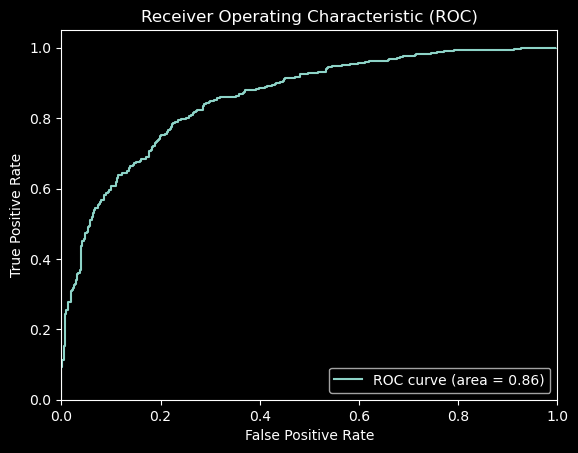

(0.7757757757757757, 0.79182156133829, 0.855819339895773)

In [33]:
test_accuracy_f1_roc_auc(lr_model4, X_train4, y_train4)

Accuracy: 0.46, F1 Score: 0.5195729537366549, ROC AUC: 0.45806836248012717


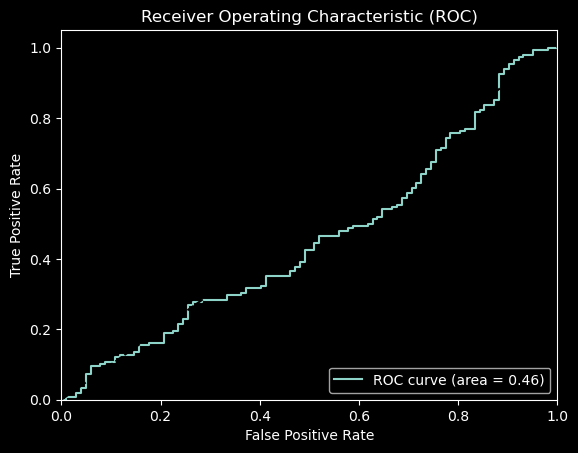

(0.46, 0.5195729537366549, 0.45806836248012717)

In [34]:
test_accuracy_f1_roc_auc(lr_model4, X_test4, y_test4)

# Random Forest

In [35]:
model_rf3 = train_random_forest(X_train3, y_train3, n_estimators=100, max_depth=None)

In [36]:
best_model_rf3 = run_grid_search(model_rf3, param_grid, X_train3, y_train3, n_splits=3)

# Display the best parameters and score
print(f"Best Parameters: {best_model_rf3.best_params_}")
print(f"Best Score: {best_model_rf3.best_score_}")

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END max_dep

Accuracy: 0.484, F1 Score: 0.5019305019305019, ROC AUC: 0.4607843137254902


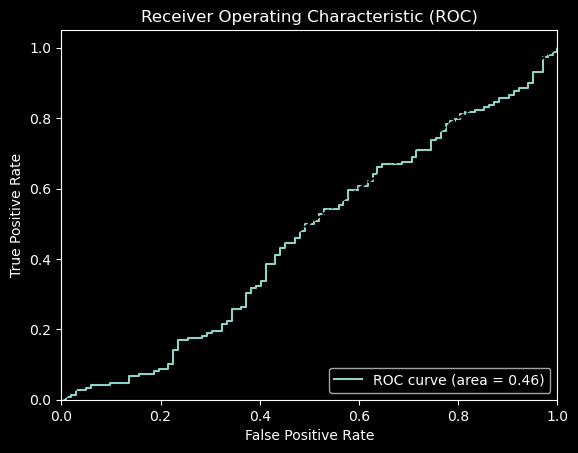

(0.484, 0.5019305019305019, 0.4607843137254902)

In [37]:
test_accuracy_f1_roc_auc(best_model_rf3, X_test3, y_test3)